### Transfer learning on Intel Image dataset (frozen vs fine-tuned MobileNetV2)

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.random.set_seed(42)

In [10]:
data_dir = 'Data/Intel Image Data/seg_train/seg_train'
img_size = (160, 160)
batch_size = 32

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    'Data/Intel Image Data/seg_test/seg_test',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
# ----- Model 1: Frozen MobileNetV2 encoder (Sequential) -----
base_model_frozen = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_frozen.trainable = False

model_frozen = tf.keras.Sequential([
    base_model_frozen,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_frozen.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
 )
model_frozen.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,598 (9.27 MB)

 Trainable params: 172,614 (674.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
history_frozen = model_frozen.fit(train_ds,
                                     epochs=5,
                                     validation_data=val_ds)
eval_frozen = model_frozen.evaluate(val_ds)
print('Frozen encoder val loss/acc:', eval_frozen)

Epoch 1/5


2026-01-06 15:53:23.591990: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4111', 204 bytes spill stores, 204 bytes spill loads

2026-01-06 15:53:23.611544: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4111_0', 464 bytes spill stores, 1372 bytes spill loads

2026-01-06 15:53:23.754766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4111', 5616 bytes spill stores, 5612 bytes spill loads

2026-01-06 15:53:23.920548: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6374', 32 bytes spill stores, 32 bytes spill loads

2026-01-06 15:53:24.040219: I

350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5834 - loss: 1.0374

2026-01-06 15:53:45.353960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4118', 12 bytes spill stores, 12 bytes spill loads

2026-01-06 15:53:45.570445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4111', 220 bytes spill stores, 220 bytes spill loads

2026-01-06 15:53:45.570575: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4111_0', 444 bytes spill stores, 1384 bytes spill loads

2026-01-06 15:53:45.679481: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4118', 4 bytes spill stores, 4 bytes spill loads

2026-01-06 15:53:45.735091: I exter

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5837 - loss: 1.0369

2026-01-06 15:53:50.651100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1171', 8 bytes spill stores, 8 bytes spill loads

2026-01-06 15:53:50.763657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1171_0', 444 bytes spill stores, 1384 bytes spill loads

2026-01-06 15:53:50.864129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178', 4 bytes spill stores, 4 bytes spill loads

2026-01-06 15:53:50.898621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178', 12 bytes spill stores, 12 bytes spill loads

2026-01-06 15:53:50.979706: I external/

351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.5839 - loss: 1.0365 - val_accuracy: 0.7250 - val_loss: 0.7427
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7234 - loss: 0.7379 - val_accuracy: 0.7367 - val_loss: 0.7354
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7462 - loss: 0.6656 - val_accuracy: 0.7250 - val_loss: 0.6690
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7567 - loss: 0.6413 - val_accuracy: 0.7583 - val_loss: 0.6643
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7678 - loss: 0.6216 - val_accuracy: 0.7600 - val_loss: 0.6640
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7651 - loss: 0.6497
Frozen encoder val loss/acc: [0.6640393733978271, 0.7599999904632568]


In [14]:
# ----- Model 2: Separate model for fine-tuning (Sequential) -----
base_model_ft = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_ft.trainable = True

# Freeze most of the encoder; fine-tune only the last ~30 layers
fine_tune_at = len(base_model_ft.layers) - 30
for layer in base_model_ft.layers[:fine_tune_at]:
    layer.trainable = False

model_ft = tf.keras.Sequential([
    base_model_ft,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
 )

history_ft = model_ft.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
 )
eval_ft = model_ft.evaluate(val_ds)
print('Fine-tuned val loss/acc:', eval_ft)

Epoch 1/5


2026-01-06 15:55:13.325723: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 691.98MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-06 15:55:13.351853: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 919.91MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5973 - loss: 1.0740

2026-01-06 15:55:35.404618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6330', 12 bytes spill stores, 12 bytes spill loads

2026-01-06 15:55:35.601672: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 691.85MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-06 15:55:35.629058: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 919.42MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.5979 - loss: 1.0726 - val_accuracy: 0.4767 - val_loss: 1.8813
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7749 - loss: 0.6032 - val_accuracy: 0.5133 - val_loss: 1.9785
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8016 - loss: 0.5349 - val_accuracy: 0.5433 - val_loss: 1.9884
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8230 - loss: 0.4787 - val_accuracy: 0.6083 - val_loss: 1.5767
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8344 - loss: 0.4383 - val_accuracy: 0.6800 - val_loss: 1.1656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6811 - loss: 1.1385
Fine-tuned val loss/acc: [1.165554165840149, 0.6800000071525574]


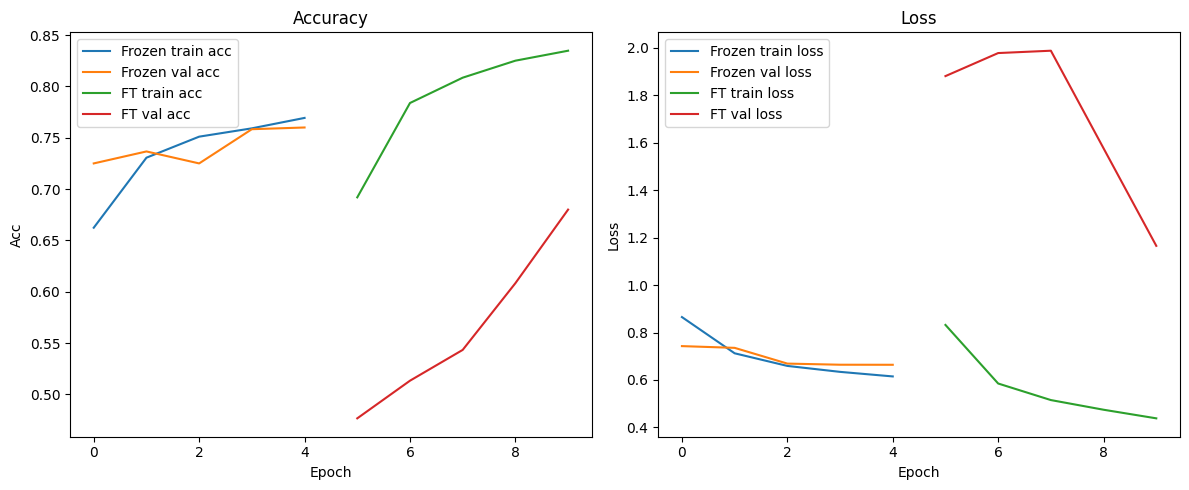

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_frozen.history['accuracy'], label='Frozen train acc')
plt.plot(history_frozen.history['val_accuracy'], label='Frozen val acc')
plt.plot([None]*len(history_frozen.history['accuracy']) + history_ft.history['accuracy'], label='FT train acc')
plt.plot([None]*len(history_frozen.history['val_accuracy']) + history_ft.history['val_accuracy'], label='FT val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_frozen.history['loss'], label='Frozen train loss')
plt.plot(history_frozen.history['val_loss'], label='Frozen val loss')
plt.plot([None]*len(history_frozen.history['loss']) + history_ft.history['loss'], label='FT train loss')
plt.plot([None]*len(history_frozen.history['val_loss']) + history_ft.history['val_loss'], label='FT val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

2026-01-06 15:57:06.928535: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



ROC AUC ANALYSIS - TRANSFER LEARNING MODELS

1. FROZEN MOBILENETV2 ENCODER


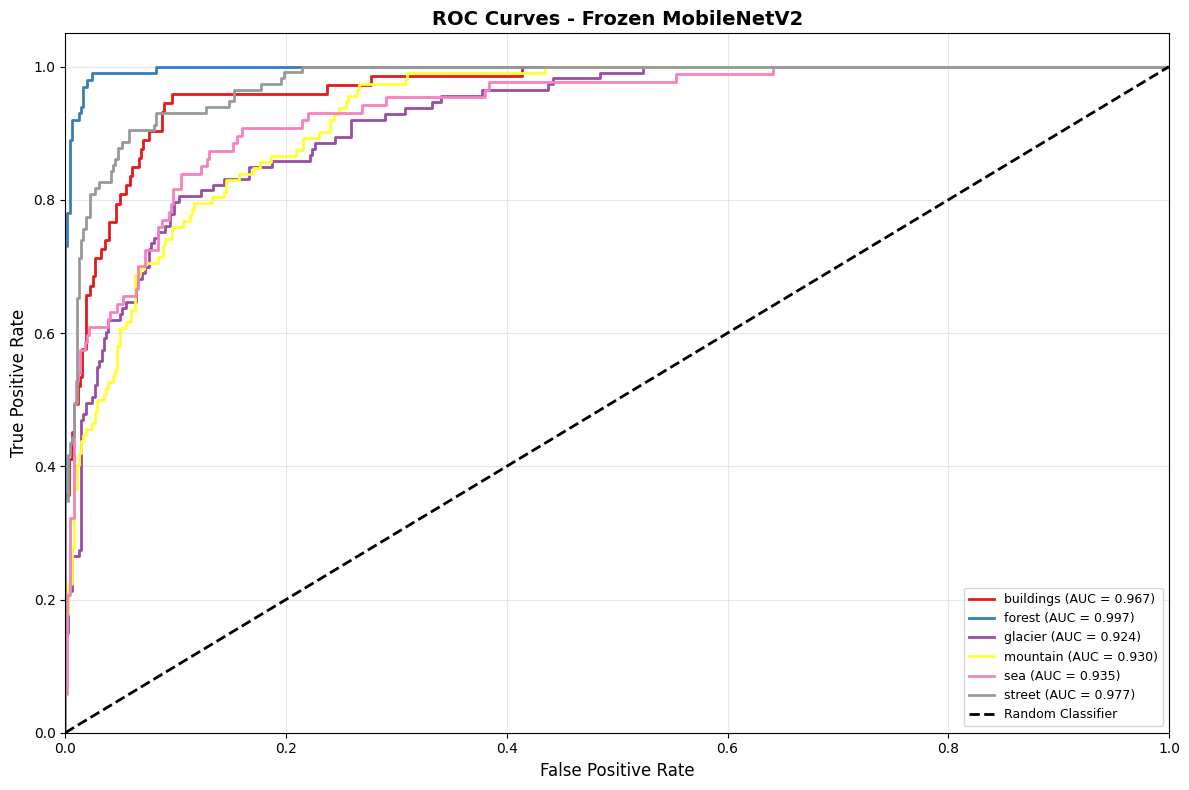

Macro-average AUC: 0.9551
Weighted-average AUC: 0.9543

2. FINE-TUNED MOBILENETV2


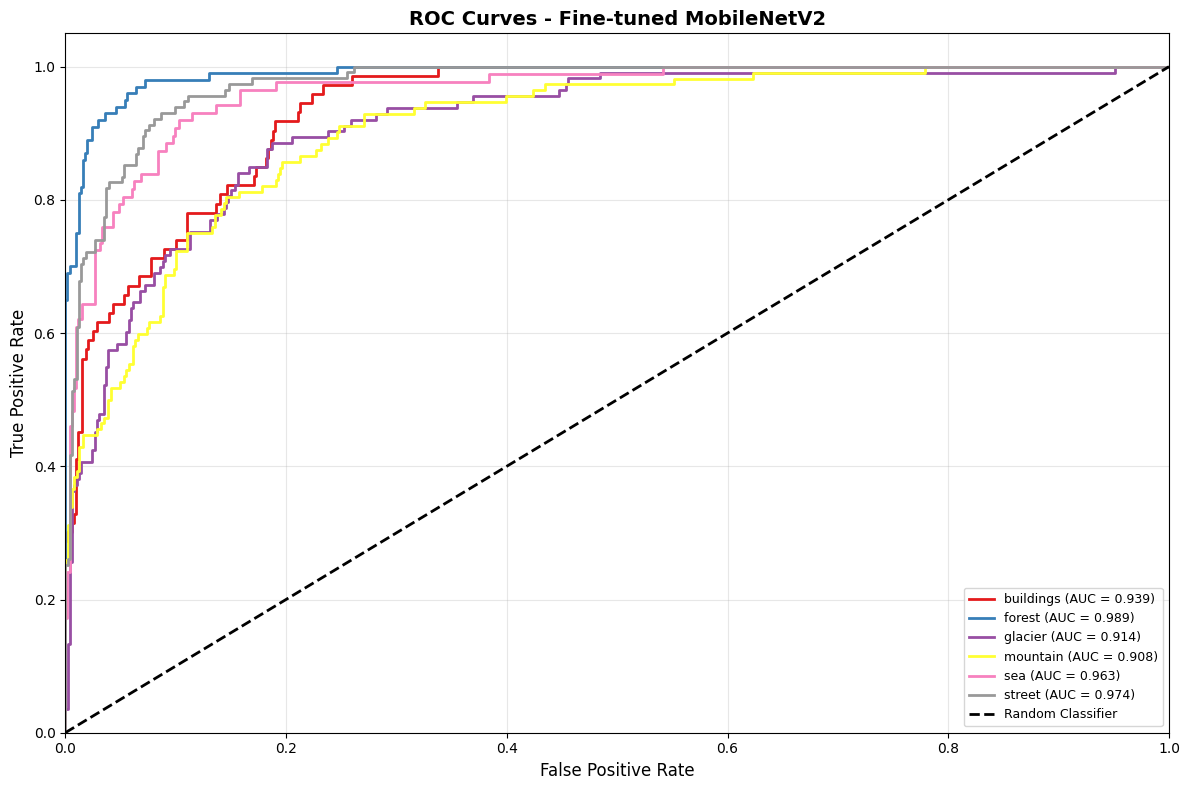

Macro-average AUC: 0.9479
Weighted-average AUC: 0.9471

MODEL COMPARISON - AUC SCORES


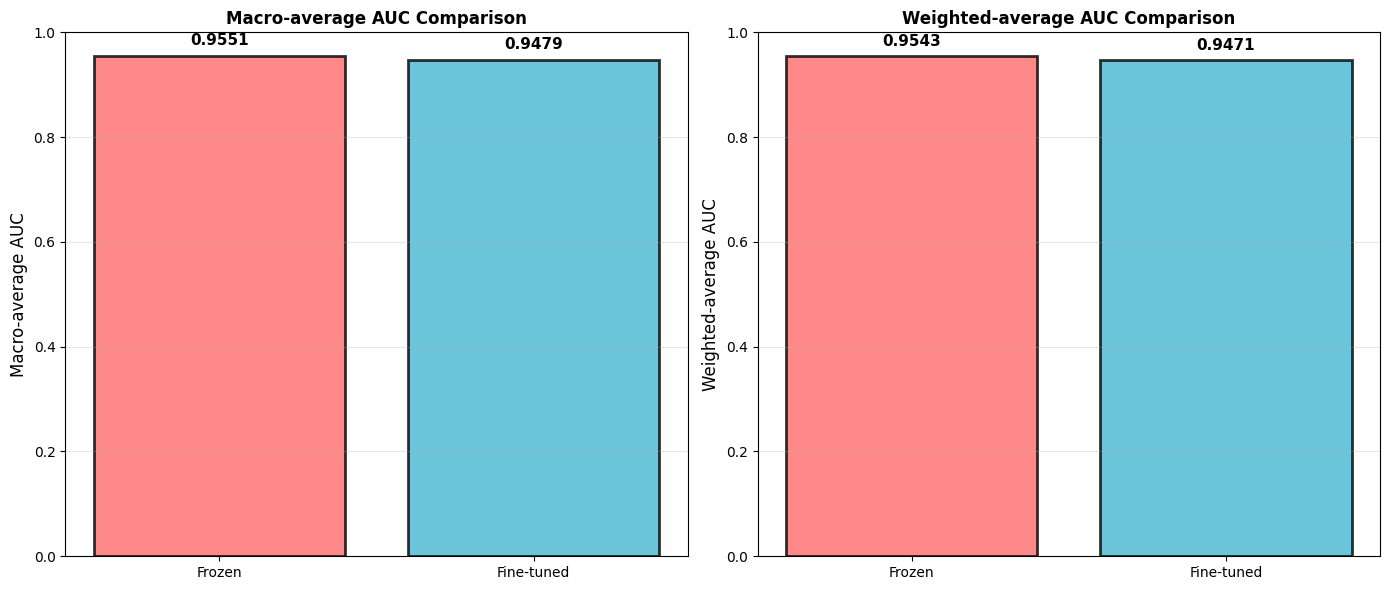


✓ Frozen model performs better with macro-average AUC = 0.9551


In [16]:

# Plot ROC AUC Curves for Multi-class Classification (One-vs-Rest)
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from both models
y_true_list = []
y_frozen_proba = []
y_ft_proba = []

for x, y in val_ds:
    y_true_list.extend(y.numpy())
    y_frozen_proba.extend(model_frozen.predict(x, verbose=0))
    y_ft_proba.extend(model_ft.predict(x, verbose=0))

y_true = np.array(y_true_list)
y_frozen_proba = np.array(y_frozen_proba)
y_ft_proba = np.array(y_ft_proba)

# Binarize the output for multi-class ROC AUC
n_classes = num_classes
y_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Function to compute and plot ROC curves
def plot_roc_multiclass(y_pred_proba, y_bin, model_name, n_classes, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc_dict = dict()
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    plt.figure(figsize=(12, 8))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, 
                label=f'{class_names[i]} (AUC = {roc_auc_dict[i]:.3f})')
    
    # Plot random classifier baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate macro and weighted averages
    macro_auc = np.mean(list(roc_auc_dict.values()))
    weights = np.bincount(y_true) / len(y_true)
    weighted_auc = np.average([roc_auc_dict[i] for i in range(n_classes)], weights=weights)
    
    return macro_auc, weighted_auc, roc_auc_dict

print("\n" + "="*70)
print("ROC AUC ANALYSIS - TRANSFER LEARNING MODELS")
print("="*70)

# Plot ROC for Frozen Model
print("\n1. FROZEN MOBILENETV2 ENCODER")
frozen_macro_auc, frozen_weighted_auc, frozen_auc_dict = plot_roc_multiclass(
    y_frozen_proba, y_bin, 'Frozen MobileNetV2', n_classes, class_names)
print(f"Macro-average AUC: {frozen_macro_auc:.4f}")
print(f"Weighted-average AUC: {frozen_weighted_auc:.4f}")

# Plot ROC for Fine-tuned Model
print("\n2. FINE-TUNED MOBILENETV2")
ft_macro_auc, ft_weighted_auc, ft_auc_dict = plot_roc_multiclass(
    y_ft_proba, y_bin, 'Fine-tuned MobileNetV2', n_classes, class_names)
print(f"Macro-average AUC: {ft_macro_auc:.4f}")
print(f"Weighted-average AUC: {ft_weighted_auc:.4f}")

# Comparison plot
print("\n" + "="*70)
print("MODEL COMPARISON - AUC SCORES")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Macro-average comparison
models = ['Frozen', 'Fine-tuned']
macro_auc_scores = [frozen_macro_auc, ft_macro_auc]
colors_bar = ['#FF6B6B', '#45B7D1']

axes[0].bar(models, macro_auc_scores, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Macro-average AUC', fontsize=12)
axes[0].set_title('Macro-average AUC Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (model, score) in enumerate(zip(models, macro_auc_scores)):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

# Weighted-average comparison
weighted_auc_scores = [frozen_weighted_auc, ft_weighted_auc]

axes[1].bar(models, weighted_auc_scores, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Weighted-average AUC', fontsize=12)
axes[1].set_title('Weighted-average AUC Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (model, score) in enumerate(zip(models, weighted_auc_scores)):
    axes[1].text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Determine winner
if ft_macro_auc > frozen_macro_auc:
    print(f"\n✓ Fine-tuned model performs better with macro-average AUC = {ft_macro_auc:.4f}")
else:
    print(f"\n✓ Frozen model performs better with macro-average AUC = {frozen_macro_auc:.4f}")
